In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import pickle
from pathlib import Path
import os
import tqdm


EPSILON = 1e-3

In [2]:
class City:

    def __init__(self, housing, amts, rho=2): #default rho (house capacity) == 2

        self.rho = rho #house capacity
        self.amts = amts #amenity list
        self.housing = housing #housing list
        
        # Create dictionary containing ID and tuple from 'housing' list
        self.housingDict = {} 
        for ID, (lat, lon, name, beltline) in enumerate(self.housing): #Iterate through each housing node
            self.housingDict[ID] = {
                'lat': lat, # Latitude
                'lon': lon, # Longitude
                'name': name, # Housing name (region)
                'beltline': beltline,  # Is it in the Beltline?
                
                'amt': False,  # Is it an amenity?
                'inh': set(),  # Set containing all Agent inhabitants
                'dow_thr': 0,  # Endowment threshold initialized to 0
                'upk': False,  # Upkeep score
                'cmt': False,  # Community score
                'pop_hist': [], # Population history
                'cmt_hist': []  # Community history
            }
            
        #Create dictionary containing ID and tuple from 'amts' list
        self.amtsDict = {}
        for ID, (lat, lon, name, beltline) in enumerate(self.amts): #Iterate through each housing node
            self.amtsDict[ID] = {
                'lat': lat, # Latitude
                'lon': lon, # Longitude
                'beltline': beltline,  # Is it in the Beltline?
                
                'amt': True,  # Is it an amenity?
                    
                'name': None, # Name
                'inh': None,  # Set containing all Agent inhabitants
                'dow_thr': None, # Endowment threshold initialized to 0
                'upk': None,  # Upkeep score
                'cmt': False,  # Community score
                'pop_hist': None,  # Population history
                'cmt_hist': None  # Community history
            }
        
        # For use in Agent class: dictionary containing all nodes
        self.allNodes = {**self.housingDict, **self.amtsDict}
           
        ''' 
        self.diam = nx.diameter(self.g, weight='length') #Longest shortest path between any two nodes on graph
        
        #Normalized shortest paths between all pairs of nodes
        self.dist = dict(nx.all_pairs_dijkstra_path_length(self.g, weight='length'))
        self.dist = pd.DataFrame.from_dict(self.dist).sort_index() / self.diam #
        self.dist = self.dist.to_numpy()'''
        # TODO: initialize self.dist
        # USED FOR COMMUNITY SCORE

        #List of distance between housing & amt
        self.amts_dist = None #Set to None for 'no amenities'
        
        # TODO: self.set_amts_dist() 
        
        self.agts = None #List of agents
        self.agt_dows = None #List of agent endowments

    # Set transit amenities [GRAPH APPROACH]
    '''def set_amts(self, amts):
        self.amts = amts
        for u in self.amts:
            data = self.housingDict[u]
            
            # Node characteristics of an amenity node
            data['amt'] = True
            data['beltline'] = self.amts[u][3]
            data['inh'] = None
            data['dow_thr'] = None
            data['upk'] = None
            data['cmt'] = None
            data['pop_hist'] = None
            data['cmt_hist'] = None
            
        # Calculate shortest distance between each housing node & transit node 
        # NECESSARY FOR ACCESSIBILITY SCORE
        if len(self.amts) == 0:
            self.amts_dist = None
        else:
            self.amts_dist = np.array([self.calcDistance(house, amenity) for house in self.housing for amenity in self.amts])'''
            #ASSUMES calcDistance(self, house, amenity) HELPER FUNCTION
        


    def set_agts(self, agts):
        self.agts = agts #list of agents
        self.agt_dows = np.array([a.dow for a in self.agts]) #list of agent endowments

    # Update each node
    def update(self):
        for ID, data in self.housingDict.items(): # Iterate through dict
            if data['amt']:
                continue
                # Skip 'amt' nodes
            
            pop = len(data['inh']) # Population
            
            # COMMUNITY SCORE (average endowment)
            if pop > 0:
                cmt = np.mean([agent.dow for agent in data['inh']]) #average of agents in set data['inh']
                # To considers weights [self.dist MUST BE DEFINED]:
                # cmt = np.average(self.agt_dows, weights=[(1 - self.dist[ID][a.ID]) ** 2 for a in self.agts])
                data['cmt'] = cmt
            else:
                data['cmt'] = 0
            
            # UPKEEP SCORE
            # ENDOWMENT THRESHOLD
            if pop > 0: # If inhabited
                if pop < self.rho:
                    data['dow_thr'] = 0
                else:
                    data['dow_thr'] = sorted([a.dow for a in data['inh']])[-self.rho] # Lowest endowment value if Population = Rho
                data['upk'] = True
                
            else: # If uninhabited
                data['dow_thr'] = 0
                data['upk'] = False

            # Update population history
            data['pop_hist'].append(pop)
            
            # Update Community history (average endowment)
            data['cmt_hist'].append(cmt)
        

#[GRAPH APPROACH]
# 'plot' function
'''
    def plot(self, cmap='YlOrRd', figkey=None):

        for u, data in self.g.nodes(data=True):
            if not data['amt']: # Non-transit nodes
                data['dow'] = np.average(self.agt_dows, weights=[a.avg_probabilities[u] for a in self.agts]) # Average endowment
                data['dow'] = (data['dow'] - min(city.agt_dows)) / (max(city.agt_dows) - min(city.agt_dows)) # Normalize
                
                data['pop'] = np.sum([a.avg_probabilities[u] for a in self.agts]) # Sum agent probabilities to be at the node
            else: # Transit nodes
                data['dow'] = np.nan
                data['pop'] = np.nan

        # ===============================
        # SIMULATION VISUALIZATION - CODE
        # ===============================
        no_agts = len(self.agts) # Number of agents
        
        
        # Size of nodes
        node_size = [no_agts / 10 * data['pop'] if not data['amt'] else no_agts / 2.5 for _, data in self.g.nodes(data=True)]
        
        # Color of nodes
        node_color = ox.plot.get_node_colors_by_attr(self.g, 'dow', start=0, stop=1, na_color='b', cmap=cmap)
        
        fig, ax = plt.subplots(figsize=(9, 6))

        # COLORBAR
        cb = fig.colorbar(
            plt.cm.ScalarMappable(cmap=plt.colormaps[cmap]), ax=ax, location='bottom', shrink=0.5, pad=0.05
        )
        cb.set_label('Expected Endowment', fontsize=14)
        
        # PLOT GRAPH
        ox.plot_graph(self.g, ax=ax, bgcolor='w', node_color=node_color, node_size=node_size)
        plt.show()
        
        if figkey is not None:
            plt.savefig('./figures/{0}.pdf'.format(figkey), bbox_inches='tight', format='pdf')
        # Save graph as pdf in './figures/' directory if 'figkey' is provided
        '''

In [3]:
class Agent:

    def __init__(self, i, dow, city, alpha=0.5):

        self.i = i # Agent instance identifier
        self.dow = dow #endowment
        self.city = city #city
        self.alpha = alpha #Transit_access/Community weight

        self.weights = None
        self.probabilities = None
        self.tot_probabilities = None
        self.avg_probabilities = None
        self.u = None

        self.reset()
        
    # Create hash identifier
    def __hash__(self):
        return hash(self.i)

    def __eq__(self, other): 
        return self.i == other.i

# RESET METHOD
    def reset(self):
        # Assign weight 1 to housing nodes, weight 0 for transit nodes
        self.weights = np.array([1.0 if not data['amt'] else 0 for data in self.city.allNodes.values()]) 
        
        # Normalize probabilities
        self.probabilities = np.array(self.weights / self.weights.sum())
        
        self.tot_probabilities = self.probabilities.copy()
        
        # Current node - Initialize starting position at random node
        self.u = np.random.choice(list(self.city.housingDict.keys()), p=self.probabilities) 
        
        # Adds self to node
        self.city.housingDict[self.u]['inh'].add(self)
        

# ACTION METHOD
    def act(self): 
        # Leave node
        self.city.housingDict[self.u]['inh'].remove(self) 
    
        # Choose another node
        self.u = np.random.choice(list(self.city.housingDict.keys()), p=self.probabilities) 
    
        # Join node
        self.city.housingDict[self.u]['inh'].add(self) 
        
# LEARN METHOD
    def learn(self):
        for ID, data in self.city.housingDict.items(): # for each node
            if not data['amt']: # if not transit 'amt'
                self.weights[ID] *= (1 - EPSILON * self.cost(ID)) # adjust probability weights based off Cost Function
        
        self.probabilities = np.array(self.weights / self.weights.sum()) # normalize weights
        self.tot_probabilities += self.probabilities # used for averaging purposes

# COST FUNCTION
    def cost(self, ID):
        
        # AFFORDABILITY
        # 1 if self.dow >= node.dow_thr; else 0
        aff = int(self.dow >= self.city.housingDict[ID]['dow_thr'])
        
        # UPKEEP
        # 1 if upkeep == True; else 0
        upk = int(self.city.housingDict[ID]['upk'])
        
        # BELTLINE
        # 1 if in beltline; else 0
        beltline = int(self.city.housingDict[ID]['beltline'])
    
        # DISTANCE
        if  self.city.amts_dist == None: #If no amenities
            loc = 1 
        else:
            loc = np.exp(- (1 - self.alpha) * self.city.amts_dist[ID])
        
        # COMMUNITY
        # Difference between node 'cmt' value and self.dow.
        cmt = np.exp(- self.alpha * np.abs(self.dow - self.city.housingDict[ID]['cmt']))
    
        # COST FUNCTION
        c = 1 - aff * loc * beltline * upk * cmt
        
        return c

In [5]:
import requests
import zipfile
from pathlib import Path
from tqdm import tqdm

def download_and_extract_file(url, filename):
    # Use a 'data' subfolder in the current working directory
    cwd = Path.cwd()
    data_dir = cwd / "data"
    data_dir.mkdir(exist_ok=True)  # Create the 'data' directory if it doesn't exist
    file_path = data_dir / filename

    # Create extraction subfolder name (remove .zip extension)
    extract_folder_name = filename.rsplit('.', 1)[0]
    extract_path = data_dir / extract_folder_name
    
    # Check if file already exists
    if file_path.exists():
        print(f"{filename} already exists in {data_dir}. Skipping download.")
    else:
        # Make the request
        print(f"Downloading {filename} to {data_dir}...")
        response = requests.get(url, stream=True)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Get the total file size
            total_size = int(response.headers.get('content-length', 0))

            # Open the file and use tqdm for the progress bar
            with file_path.open('wb') as file, tqdm(
                desc=filename,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as progress_bar:
                for data in response.iter_content(chunk_size=1024):
                    size = file.write(data)
                    progress_bar.update(size)
            print(f"Successfully downloaded {filename}")
        else:
            print(f"Failed to download {filename}. Status code: {response.status_code}")
            return

    # Extract the ZIP file
    print(f"Extracting {filename} to {extract_path}...")
    extract_path.mkdir(exist_ok=True)  # Create the extraction folder if it doesn't exist
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        # Get the total number of files in the ZIP
        total_files = len(zip_ref.infolist())
        
        # Use tqdm for the extraction progress bar
        for file in tqdm(zip_ref.infolist(), desc="Extracting", total=total_files):
            zip_ref.extract(file, extract_path)
    
    print(f"Successfully extracted {filename} to {extract_path}")

# URL of the file to download
url = "https://www2.census.gov/geo/tiger/TIGER2022/ZCTA520/tl_2022_us_zcta520.zip"

# Filename to save as
filename = "tl_2022_us_zcta520.zip"

# Call the function to download and extract the file
download_and_extract_file(url, filename)

tl_2022_us_zcta520.zip already exists in c:\Users\kmmat\OneDrive\Desktop\VIP\24Fa-MPONC\modeling_processes_of_neighborhood_change_new\data. Skipping download.
Extracting tl_2022_us_zcta520.zip to c:\Users\kmmat\OneDrive\Desktop\VIP\24Fa-MPONC\modeling_processes_of_neighborhood_change_new\data\tl_2022_us_zcta520...


Extracting: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

Successfully extracted tl_2022_us_zcta520.zip to c:\Users\kmmat\OneDrive\Desktop\VIP\24Fa-MPONC\modeling_processes_of_neighborhood_change_new\data\tl_2022_us_zcta520


c:\Users\kmmat\OneDrive\Desktop\VIP\24Fa-MPONC\modeling_processes_of_neighborhood_change_new
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14


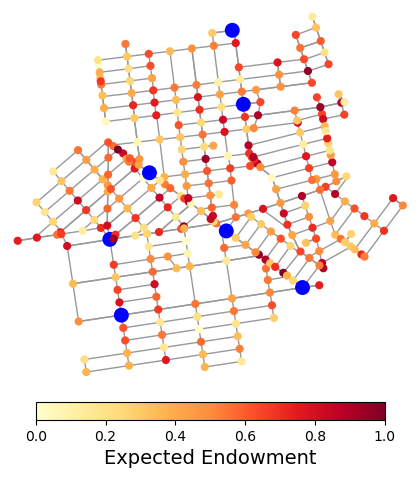

<Figure size 640x480 with 0 Axes>

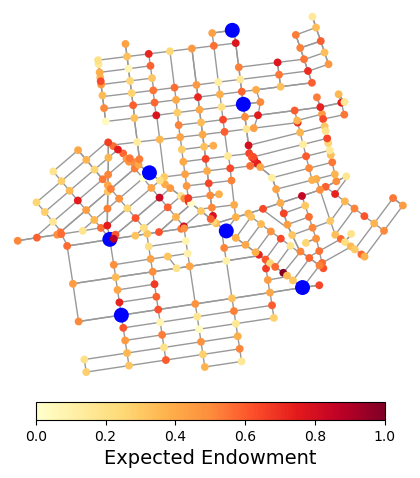

<Figure size 640x480 with 0 Axes>

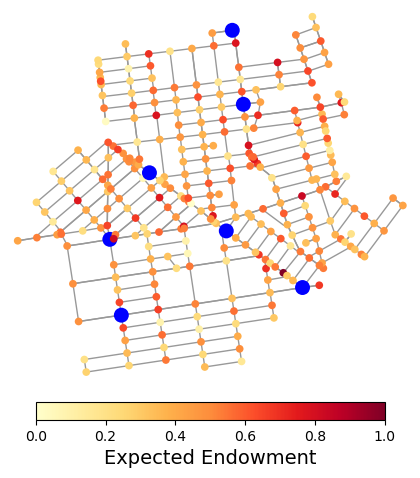

<Figure size 640x480 with 0 Axes>

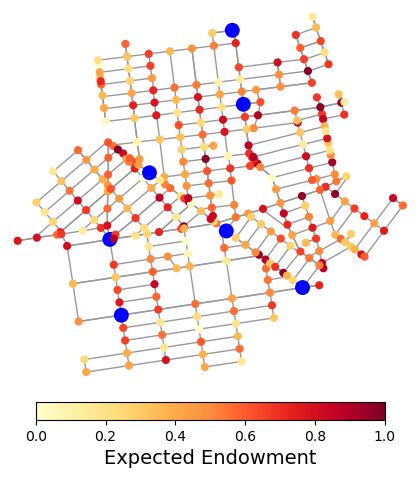

<Figure size 640x480 with 0 Axes>

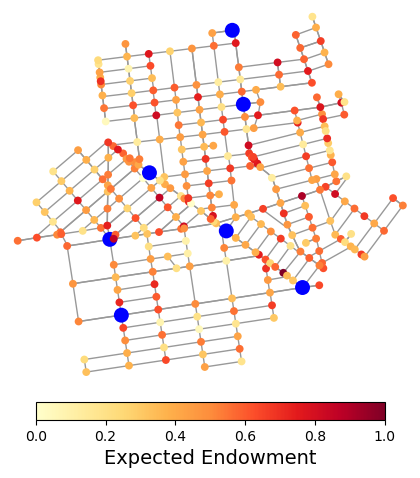

<Figure size 640x480 with 0 Axes>

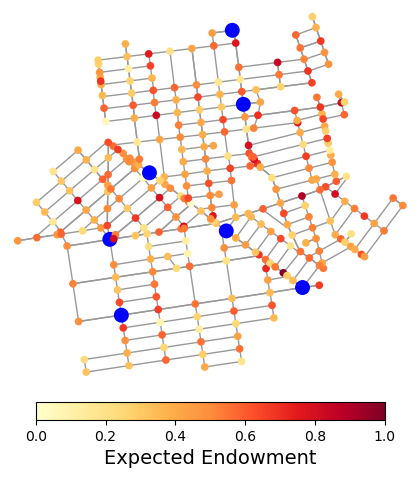

<Figure size 640x480 with 0 Axes>

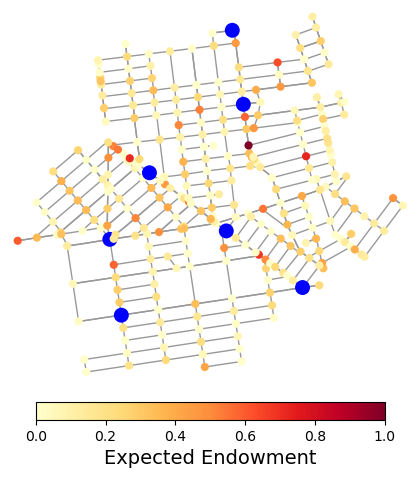

<Figure size 640x480 with 0 Axes>

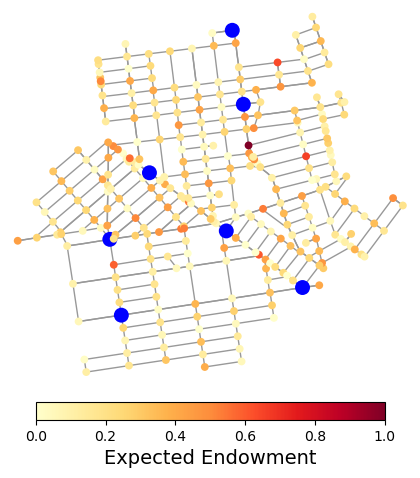

<Figure size 640x480 with 0 Axes>

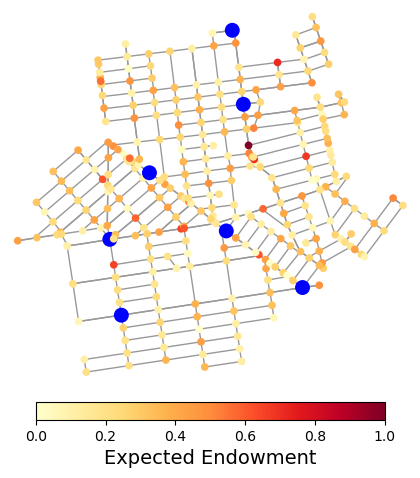

<Figure size 640x480 with 0 Axes>

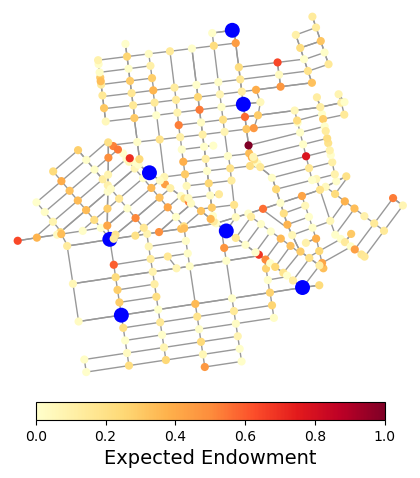

<Figure size 640x480 with 0 Axes>

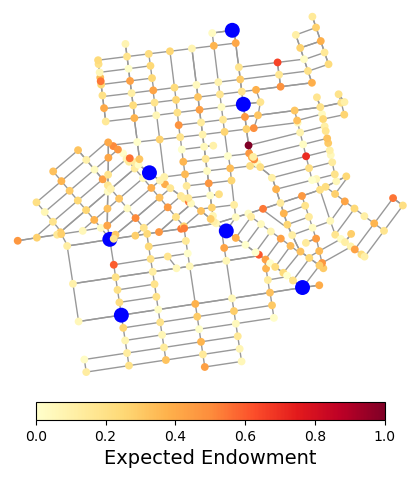

<Figure size 640x480 with 0 Axes>

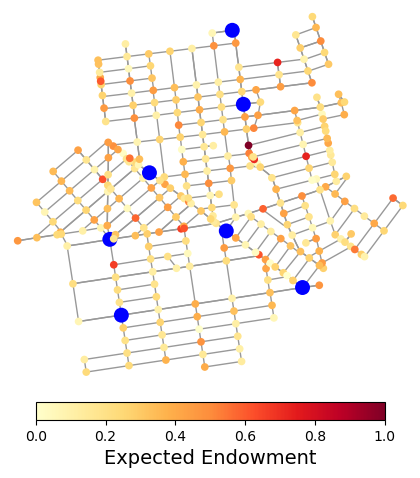

<Figure size 640x480 with 0 Axes>

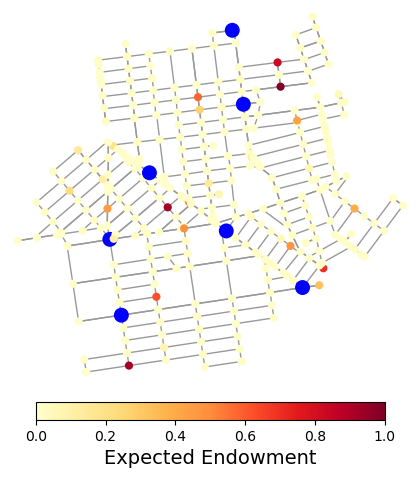

<Figure size 640x480 with 0 Axes>

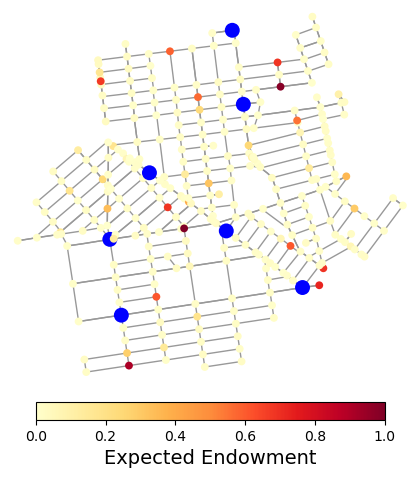

<Figure size 640x480 with 0 Axes>

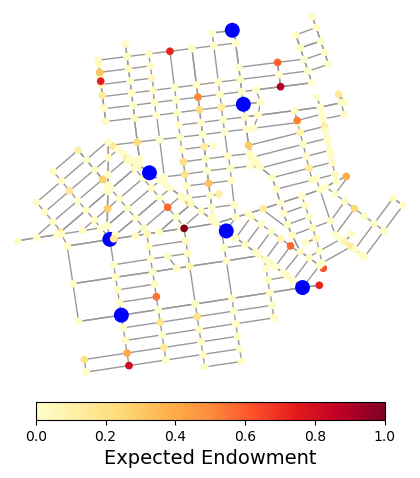

<Figure size 640x480 with 0 Axes>

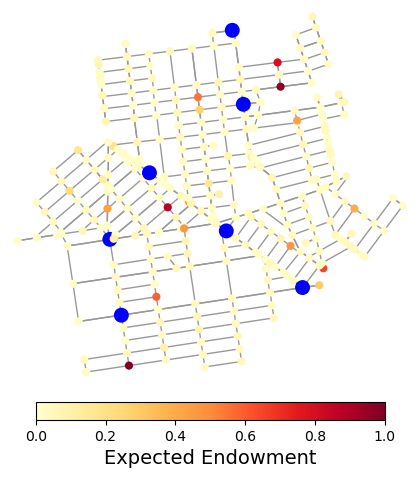

<Figure size 640x480 with 0 Axes>

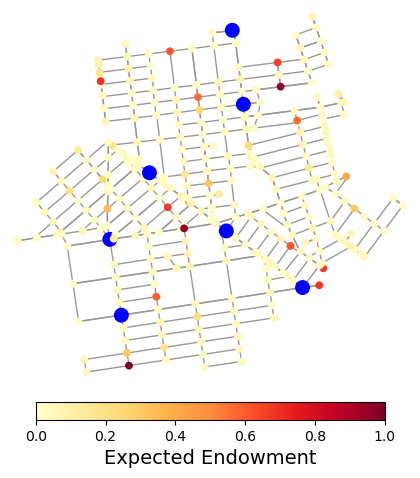

<Figure size 640x480 with 0 Axes>

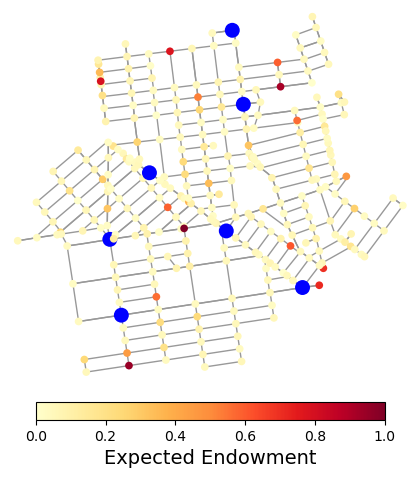

<Figure size 640x480 with 0 Axes>

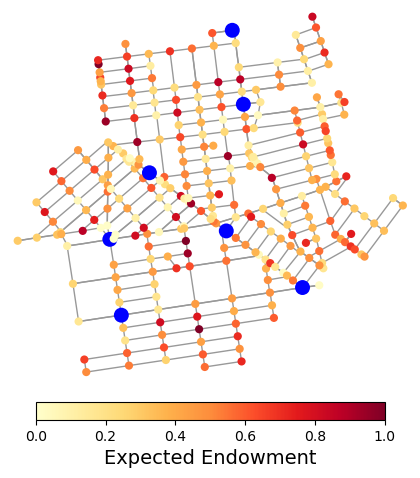

<Figure size 640x480 with 0 Axes>

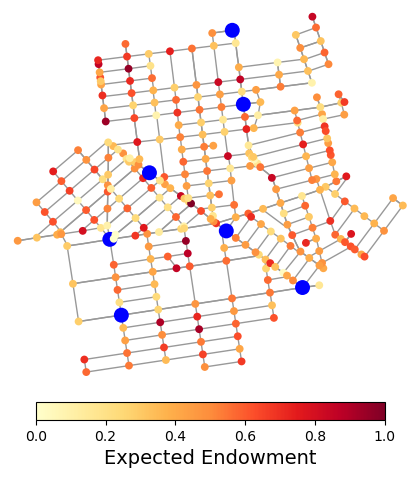

<Figure size 640x480 with 0 Axes>

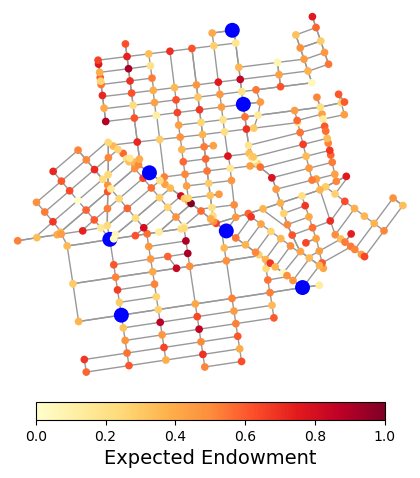

<Figure size 640x480 with 0 Axes>

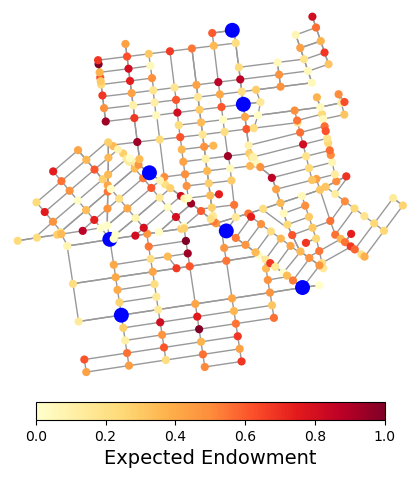

<Figure size 640x480 with 0 Axes>

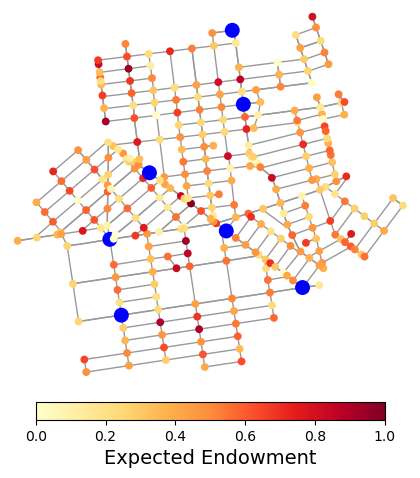

<Figure size 640x480 with 0 Axes>

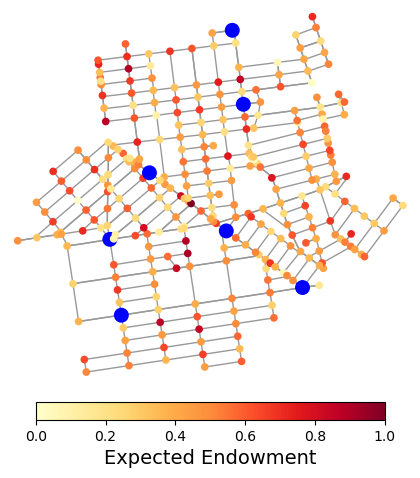

<Figure size 640x480 with 0 Axes>

In [6]:
cwd = Path.cwd()
print(cwd)
figures_folder = Path(cwd / "figures")
if not os.path.isdir(figures_folder):
    os.makedirs(figures_folder)


# Housing amenities [manual]
# Use dummy coordinates for now
housing = [
    (0.0, 0.0, 'RDA/Cascade', True),
    (0.0, 0.0, 'Pittsburgh/Peoplestown', True),
    (0.0, 0.0, 'Boulevard Crossing', True),
    (0.0, 0.0, 'Memorial Drive/Glenwood', True),
    (0.0, 0.0, 'Freedom Parkway', True),
    (0.0, 0.0, 'Virginia Highlands/Ansley', True),
    (0.0, 0.0, 'Peachtree/Collier', True),
    (0.0, 0.0, 'Upper Westside/Northside', True),
    (0.0, 0.0, 'Simpson/Hollowell', True),
    (0.0, 0.0, 'Upper Marietta/Westside Park', True)
]

# (GRAPH APPROACH - automate creation of nodes)
'''
load_g = False
if not load_g:
    gdf = gpd.read_file(cwd / Path('data/tl_2022_us_zcta520/tl_2022_us_zcta520.shp'))
    gdf = gdf[gdf['ZCTA5CE20'] == '11206']
    shape = gdf.iloc[0].geometry
    g = ox.graph_from_polygon(shape, network_type='drive', simplify=True)
    g = g.subgraph(max(nx.strongly_connected_components(g), key=len)).copy()
    g = nx.convert_node_labels_to_integers(g)
    with open(Path(cwd / 'data/tl_2022_us_zcta520/williamsburg.pkl'), 'wb') as file:
        pickle.dump(g, file)
else:
    with open(Path(cwd / 'data/tl_2022_us_zcta520/williamsburg.pkl'), 'rb') as file:
        g = pickle.load(file)
amts = [ox.nearest_nodes(g, lon, lat) for lat, lon, _ in stations]
'''

# For now, don't consider transit amenities:
# Tuple format: (lat) float, (lon) float, (name) string, (in beltline?) boolean
amts = []


# ====================================
# SIMULATION PRE-DETERMINED PARAMETERS
# ====================================
rho_l = [1, 2, 4, 8] # (for each iteration) rho-house capacity
alpha_l = [0.25, 0.75] # (for each iteration) lambda-transit access vs. community value
t_max_l = [5000, 10000, 15000, 20000] # (for each iteration) timesteps
tau = 0.5 # inequality factor in Lorentz curve

# RUN SIMULATION?
run_experiments = True

# PLOT SIMULATION?
plot_cities = True

cty_key = 'williamsburg'


# ===============
# SIMULATION CODE
# ===============

if run_experiments:
    for rho in rho_l:
        for alpha in alpha_l:

            np.random.seed(0)

            city = City(housing, amts, rho=rho)
            #city.set_amts(amts) [graph approach to setting amenities]
            n = len(city.allNodes)
            
            agt_dows = np.diff([1 - (1 - x) ** tau for x in np.linspace(0, 1, n + 1)])
            agts = [Agent(i, dow, city, alpha=alpha) for i, dow in enumerate(agt_dows)]

            city.set_agts(agts)
            city.update()

            for t in range(max(t_max_l)):
                print('t: {0}'.format(t))
                for a in agts:
                    a.act()
                city.update()
                for a in agts:
                    a.learn()

                if t + 1 in t_max_l:

                    for a in city.agts:
                        a.avg_probabilities = a.tot_probabilities / (t + 1)

                    with open(Path(cwd / 'data/{0}_{1}_{2}_{3}.pkl'.format(cty_key, rho, alpha, t + 1)), 'wb') as file:
                        pickle.dump(city, file)

#[GRAPH APPROACH]
#TODO: figure out how to visualize
'''
if plot_cities:
    for rho in rho_l:
        for alpha in alpha_l:
            for t_max in t_max_l:
                with open(Path(cwd / 'data/{0}_{1}_{2}_{3}.pkl'.format(cty_key, rho, alpha, t_max)), 'rb') as file:
                    city = pickle.load(file)
                cmap = 'YlOrRd'
                figkey = '{0}_{1}_{2}_{3}'.format(cty_key, rho, alpha, t_max)
                city.plot(cmap=cmap, figkey=figkey)
                '''